In [1]:
# Authored by Konstantinos Theofilatos 11.12.2024
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# set this to True if you use Google Colab
runOnGoogle = False
if runOnGoogle:
    from google.colab import files    

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/theofil/I2TheTerascale/blob/main/code/python/analyzeCSV.ipynb)

In [2]:
# CSV files, chose which ever you like from https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/
path = 'https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/'
df = pd.read_csv('https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/2mu.inclusive.all.csv')

In [3]:
df.head()

,EventWeight,triggerIsoMu24,NPrimaryVertices,NMuon,Muon_Px_0,Muon_Px_1,Muon_Py_0,Muon_Py_1,Muon_Pz_0,Muon_Pz_1,...,Muon_Charge_0,Muon_Charge_1,Muon_Iso_0,Muon_Iso_1,NJet,NElectron,NPhoton,MET_px,MET_py,sampleID
0,1.0,True,4,2,7.0,-3.4,-29.8,27.5,-27.5,40.2,...,-1.0,1.0,0.6,0.3,0.0,0.0,0.0,10.4,-4.0,0.0
1,1.0,True,4,2,-26.7,13.7,10.1,18.0,3.8,-0.5,...,-1.0,1.0,0.0,2.0,0.0,0.0,1.0,13.8,-5.4,0.0
2,1.0,True,8,2,38.4,-34.8,-25.9,20.2,-83.8,-34.6,...,1.0,-1.0,2.3,0.0,0.0,0.0,0.0,-7.2,5.5,0.0
3,1.0,True,5,2,-30.3,19.6,45.6,-30.3,158.0,55.1,...,-1.0,1.0,4.2,3.1,0.0,0.0,0.0,23.7,-24.2,0.0
4,1.0,True,5,2,-25.3,19.8,-7.6,13.7,-87.3,9.6,...,-1.0,1.0,3.3,1.5,0.0,0.0,0.0,4.7,7.3,0.0


In [4]:
def makePlot(
    df, var, xmin=0, xmax=5, step_size=1, ylog=False, saveFig=False, 
    xlabel='', ylabel='', printOut=True, plot_ratio=True):
    dfs = []
    
    # Define samples with labels, colors, and color descriptions
    samples = [
        {"label": "Data",       "color": "#000000", "color_name": "black"},
        {"label": "QCD",        "color": "#9467bd", "color_name": "purple"}, 
        {"label": "WJets",      "color": "#1f77b4", "color_name": "blue"},
        {"label": "Top",        "color": "#ff7f0e", "color_name": "orange"},
        {"label": "WW",         "color": "#2ca02c", "color_name": "green"},
        {"label": "TTbar",      "color": "#d62728", "color_name": "red"},
        {"label": "WZ",         "color": "#e377c2", "color_name": "pink"},
        {"label": "ZZ",         "color": "#7f7f7f", "color_name": "gray"},
        {"label": "DY",         "color": "#bcbd22", "color_name": "yellow-green"},
    ]

    labels = [sample["label"] for sample in samples]
    colors = [sample["color"] for sample in samples]

    for i in range(9):
        tmp_df = df[df.sampleID == i]
        tmp_df.attrs['label'] = labels[i]
        tmp_df.attrs['color'] = colors[i]
        print('sampleID = %d  %s'%(i,labels[i]))
        if(len(tmp_df)>0): dfs.append(tmp_df)
            
    # reset labels and colors to show only relevant non-null samples
    labels = []
    colors = []
    for df in dfs:
        labels += [df.attrs['label']]
        colors += [df.attrs['color']]
  
    plotMCstack = len(dfs) >= 2
    
    bin_edges = np.arange(start=xmin, stop=xmax + step_size, step=step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    for df in dfs:
        df.attrs['histo'] = np.histogram(df[var], bins=bin_edges, weights=df['EventWeight'])[0]
        df.attrs['histoError'] = np.sqrt(np.histogram(df[var], bins=bin_edges, weights=df['EventWeight']**2)[0])

    # Figure layout: main plot + optional ratio plot
    if plot_ratio and len(dfs)>=2:
        fig = plt.figure(figsize=(6, 8))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax_main = fig.add_subplot(gs[0])
        ax_ratio = fig.add_subplot(gs[1])
    else:
        fig, ax_main = plt.subplots(figsize=(6, 6))
    
    # MC Stack Plot
    if plotMCstack:
        mcHistosEntries = [df[var] for df in dfs[1:]]
        mcHistosWeights = [df['EventWeight'] for df in dfs[1:]]
        mcHistoStack = ax_main.hist(
            mcHistosEntries, bins=bin_edges, weights=mcHistosWeights, 
            stacked=True, histtype='stepfilled', label=labels[1:], color=colors[1:], alpha=0.8
        )[0]
        mcHistoTot = mcHistoStack[-1]
        mcHistoTotError = np.sqrt(np.histogram(
            np.hstack(mcHistosEntries), bins=bin_edges, weights=np.hstack(mcHistosWeights)**2
        )[0])

        # Add total background prediction as black line
        ax_main.step(
            bin_edges[:-1], mcHistoTot, where='post', color='black', linestyle='-', linewidth=3, 
            label='Total'
        )

        # Add hatched band for total MC uncertainty
        ax_main.fill_between(
            bin_edges[:-1], mcHistoTot - mcHistoTotError, mcHistoTot + mcHistoTotError,
            step='post', color='gray', alpha=0.5, hatch='/', label='Unc.'
        )

    dataHisto = np.histogram(dfs[0][var], bins=bin_edges, weights=dfs[0]['EventWeight'])[0]
    dataHistoError = np.sqrt(np.histogram(
        dfs[0][var], bins=bin_edges, weights=dfs[0]['EventWeight']**2
    )[0])

    # Plot data points with larger markers
    ax_main.errorbar(
        bin_centres, dataHisto, yerr=dataHistoError, fmt='o', color='black', capsize=4, capthick=1, markersize=8, label=labels[0]
    ) 

    # Decorations for CMS-style
    ax_main.set_xlabel('' if plot_ratio else (xlabel if xlabel else var), fontsize=18, loc='right')
    ax_main.set_ylabel(rf'{ylabel if ylabel else "Events / bin"}', fontsize=18, loc='top')
    ax_main.set_yscale('log' if ylog else 'linear')
    ax_main.set_xlim(xmin, xmax)
    ax_main.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
    ax_main.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
    
    # Updated legend: two-column layout
    ax_main.legend(fontsize=14, loc='upper right', frameon=False, ncol=2)

    # Ensure "Data" appears first in the legend
    handles, legends = ax_main.get_legend_handles_labels()
    if len(dfs)>=2:
        ordered_handles = [handles[legends.index('Data')]] + [h for h, l in zip(handles, legends) if l != 'Data']
        ordered_legends = ['Data'] + [l for l in legends if l != 'Data']
    else:
        sampleName = dfs[0].attrs['label']
        ordered_handles = [handles[legends.index(sampleName)]] + [h for h, l in zip(handles, legends) if l != sampleName]
        ordered_legends = [sampleName] + [l for l in legends if l != sampleName]
 
    ax_main.legend(ordered_handles, ordered_legends, fontsize=14, loc='upper right', frameon=False, ncol=2)

    # Add transparent background
    fig.patch.set_alpha(0)
    ax_main.set_facecolor('none')

    if plot_ratio and len(dfs)>=2:
        # Ratio plot
        ratio = np.divide(dataHisto, mcHistoTot, out=np.zeros_like(dataHisto, dtype=float), where=mcHistoTot != 0)
        ratio_errors = np.divide(dataHistoError, mcHistoTot, out=np.zeros_like(dataHistoError, dtype=float), where=mcHistoTot != 0)

        ax_ratio.errorbar(
            bin_centres, ratio, yerr=ratio_errors, fmt='o', color='black', capsize=4, capthick=1, markersize=8
        )
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        ax_ratio.set_xlim(xmin, xmax)
        ax_ratio.set_ylim(0.1, 1.9)  # Updated y-axis range
        ax_ratio.set_xlabel(rf'{xlabel if xlabel else var}', fontsize=18, loc='right')
        ax_ratio.set_ylabel('Data / MC', fontsize=14, loc='center')
        ax_ratio.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
        ax_ratio.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
        ax_ratio.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
        # Hide x-axis tick labels in the top panel
        ax_main.tick_params(axis='x', which='both', labelbottom=False)

    if not plot_ratio: plt.tight_layout()

    if saveFig:
        plt.savefig(f"{var}.pdf")
        plt.savefig(f"{var}.png")
        if runOnGoogle:
            files.download(var+'.pdf') 
            files.download(var+'.png') 


    plt.show()

        # calculate statistics summary
    Data      = sum(dfs[0].attrs['histo'])
    DataError = sum([err**2 for err in dfs[0].attrs['histoError']])**0.5
    if(len(dfs)>=2):
        MC        = sum(mcHistoTot)
        MCError   = sum([err**2 for err in mcHistoTotError])**0.5

    nEntriesData = len(dfs[0])
    nEntriesMC   = 0
    for df in dfs[1:]: nEntriesMC += len(df)

    print('%s: %2.1f ± %2.1f [entries: %d]'%(dfs[0].attrs['label'],Data, DataError, nEntriesData))
    if(len(dfs)>=2):
        print('MC  : %2.1f ± %2.1f [entries: %d]'%(MC,     MCError, nEntriesMC))

    # calculate totEvents and totEventsError for each dataframe
    for df in dfs:
        df.attrs['totEvents'] = sum(df.attrs['histo'])
        df.attrs['totEventsError'] = sum(df.attrs['histoError']**2)**0.5


    # print totEvents and totEventsError for MC
    print('-----------------------------')    
    for df in dfs[1:]:
        print('%s  %2.1f ± %2.1f  [entries: %d]'%(df.attrs['label'], df.attrs['totEvents'], df.attrs['totEventsError'], len(df)))        

    print('-----------------------------')        

    # detailed print out if user has requested so using printOut = True
    if printOut:
        # print info for data and MC
        print('')
        print('### printing number of events for each bin and its estimated uncertainty ###')
        print('###       disable this if you wish by setting printOut = False           ###')
        print('')

        for df in dfs[0:1]:
            output = df.attrs['label']+' ['
            outputError = df.attrs['label'] + 'Error ['

            for ibin in range(len(df.attrs['histo'])):
                output += ' %2.1f, '%df.attrs['histo'][ibin]
                outputError += ' %2.1f, '%df.attrs['histoError'][ibin]

            output += ' ]'
            outputError += ' ]'

            print (output)
            print (outputError)

        output = 'MCTot = ['  
        outputError = 'MCTotError = ['
        for ibin in range(len(mcHistoTot)):
            output += ' %2.1f, '%mcHistoTot[ibin]
            outputError += ' %2.1f '%mcHistoTotError[ibin]

        output += ' ]'
        outputError += ' ]'
        print (output)
        print (outputError)

        print('')
        print('### detailed analysis of MC ###')
        print('')

        for df in dfs[1:]:
            output = df.attrs['label']+' = ['
            outputError = df.attrs['label'] + 'Error = ['

            for ibin in range(len(df.attrs['histo'])):
                output += ' %2.1f, '%df.attrs['histo'][ibin]
                outputError += ' %2.1f, '%df.attrs['histoError'][ibin]

            output += ' ]'
            outputError += ' ]'

            print (output)
            print (outputError)

sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


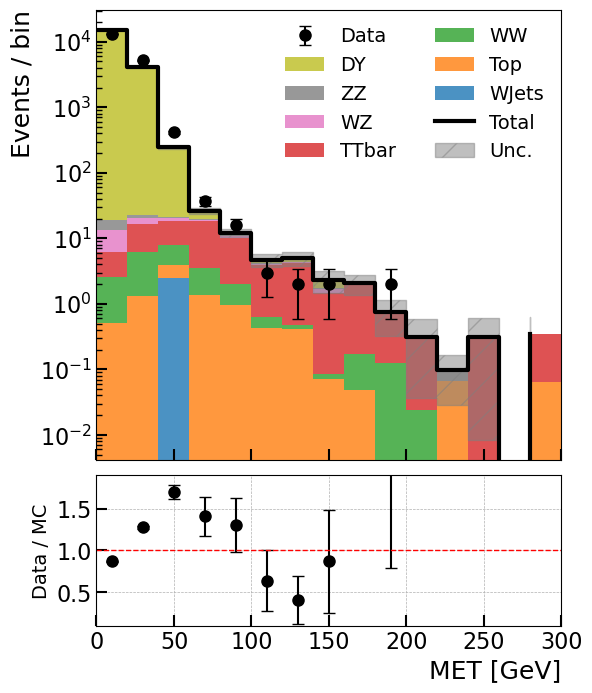

Data: 18707.0 ± 136.8 [entries: 18708]
MC  : 19362.6 ± 103.4 [entries: 46863]
-----------------------------
WJets  2.5 ± 2.2  [entries: 2]
Top  6.7 ± 0.6  [entries: 129]
WW  14.6 ± 0.9  [entries: 289]
TTbar  59.1 ± 4.0  [entries: 262]
WZ  15.1 ± 0.6  [entries: 719]
ZZ  10.1 ± 0.3  [entries: 1413]
DY  19254.4 ± 103.2  [entries: 44049]
-----------------------------

### printing number of events for each bin and its estimated uncertainty ###
###       disable this if you wish by setting printOut = False           ###

Data [ 13042.0,  5187.0,  416.0,  37.0,  16.0,  3.0,  2.0,  2.0,  0.0,  2.0,  0.0,  0.0,  0.0,  0.0,  0.0,  ]
DataError [ 114.2,  72.0,  20.4,  6.1,  4.0,  1.7,  1.4,  1.4,  0.0,  1.4,  0.0,  0.0,  0.0,  0.0,  0.0,  ]
MCTot = [ 14997.0,  4066.3,  245.0,  26.2,  12.2,  4.7,  5.0,  2.3,  2.1,  0.7,  0.3,  0.1,  0.3,  0.0,  0.3,  ]
MCTotError = [ 91.6  46.5  10.5  2.6  1.7  1.1  1.1  0.8  0.7  0.4  0.3  0.1  0.3  0.0  0.3  ]

### detailed analysis of MC ###

WJets = [ 0.0,  0.

In [5]:
df['MET'] = (df["MET_px"]**2 + df["MET_py"]**2)**0.5
makePlot(df, var="MET", xmin=0, xmax=300, step_size=20, ylog = True, saveFig = False, xlabel = 'MET [GeV]', ylabel = '', printOut=True, plot_ratio= True)

In [6]:
# import vector
# # Define the invariant mass column
# def calculate_invariant_mass(row):
#     muon_0 = vector.obj(px=row['Muon_Px_0'], py=row['Muon_Py_0'], pz=row['Muon_Pz_0'], E=row['Muon_E_0'])
#     muon_1 = vector.obj(px=row['Muon_Px_1'], py=row['Muon_Py_1'], pz=row['Muon_Pz_1'], E=row['Muon_E_1'])
#     combined = muon_0 + muon_1
#     return combined.mass

def calculate_invariant_mass(row):
    p2 = (row['Muon_Px_0'] + row['Muon_Px_1'])**2 + (row['Muon_Py_0']+row['Muon_Py_1'])**2 + (row['Muon_Pz_0']+row['Muon_Pz_1'])**2
    E2 = (row['Muon_E_0'] + row['Muon_E_1'])**2
    res = 0
    if E2 > p2: res = (E2-p2)**0.5 # sometimes due to roundings it could happen to have imaginary mass
    return res

# Apply the function to each row
df['invM'] = df.apply(calculate_invariant_mass, axis=1)

# Output the DataFrame
df.head()

,EventWeight,triggerIsoMu24,NPrimaryVertices,NMuon,Muon_Px_0,Muon_Px_1,Muon_Py_0,Muon_Py_1,Muon_Pz_0,Muon_Pz_1,...,Muon_Iso_0,Muon_Iso_1,NJet,NElectron,NPhoton,MET_px,MET_py,sampleID,MET,invM
0,1.0,True,4,2,7.0,-3.4,-29.8,27.5,-27.5,40.2,...,0.6,0.3,0.0,0.0,0.0,10.4,-4.0,0.0,11.142711,88.996966
1,1.0,True,4,2,-26.7,13.7,10.1,18.0,3.8,-0.5,...,0.0,2.0,0.0,0.0,1.0,13.8,-5.4,0.0,14.818907,40.895721
2,1.0,True,8,2,38.4,-34.8,-25.9,20.2,-83.8,-34.6,...,2.3,0.0,0.0,0.0,0.0,-7.2,5.5,0.0,9.060353,89.708862
3,1.0,True,5,2,-30.3,19.6,45.6,-30.3,158.0,55.1,...,4.2,3.1,0.0,0.0,0.0,23.7,-24.2,0.0,33.872260,92.854994
4,1.0,True,5,2,-25.3,19.8,-7.6,13.7,-87.3,9.6,...,3.3,1.5,0.0,0.0,0.0,4.7,7.3,0.0,8.682166,87.356110


sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


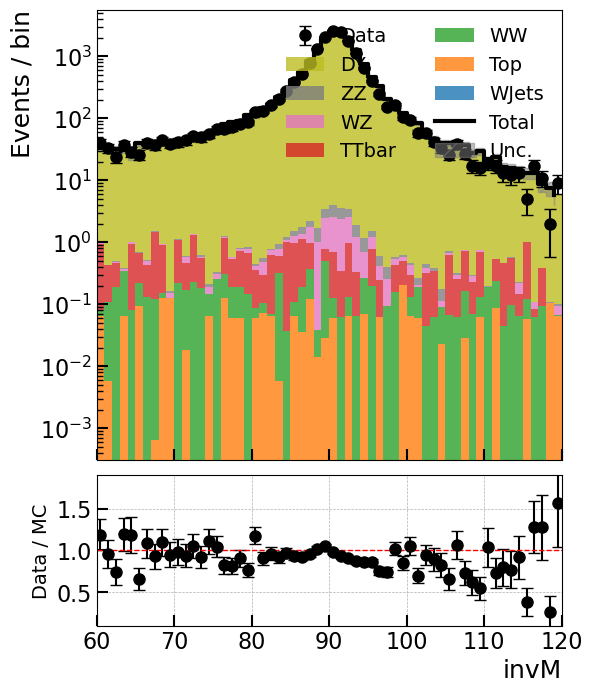

Data: 17057.0 ± 130.6 [entries: 18708]
MC  : 18106.5 ± 94.9 [entries: 46863]
-----------------------------
WJets  0.0 ± 0.0  [entries: 2]
Top  2.3 ± 0.4  [entries: 129]
WW  6.6 ± 0.6  [entries: 289]
TTbar  23.5 ± 2.5  [entries: 262]
WZ  13.8 ± 0.6  [entries: 719]
ZZ  9.3 ± 0.3  [entries: 1413]
DY  18050.9 ± 94.8  [entries: 44049]
-----------------------------


In [7]:
makePlot(df, var = 'invM', xmin=60, xmax = 120,step_size=1, ylog= True, printOut=False)

sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


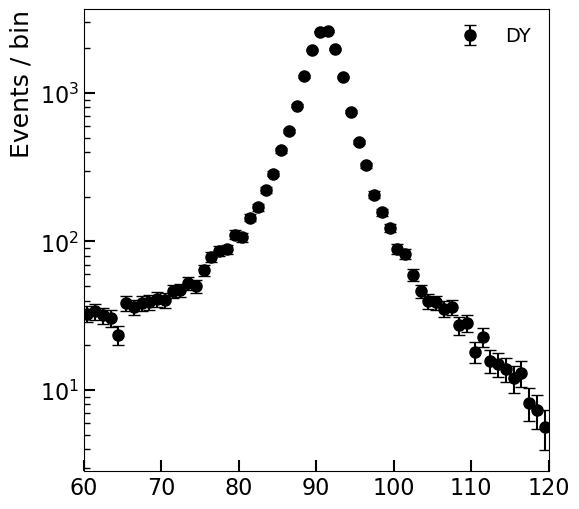

DY: 18050.9 ± 94.8 [entries: 44049]
-----------------------------
-----------------------------


In [8]:
makePlot(df[df.sampleID==8], var = 'invM', xmin=60, xmax = 120,step_size=1, ylog= True, printOut=False)

sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


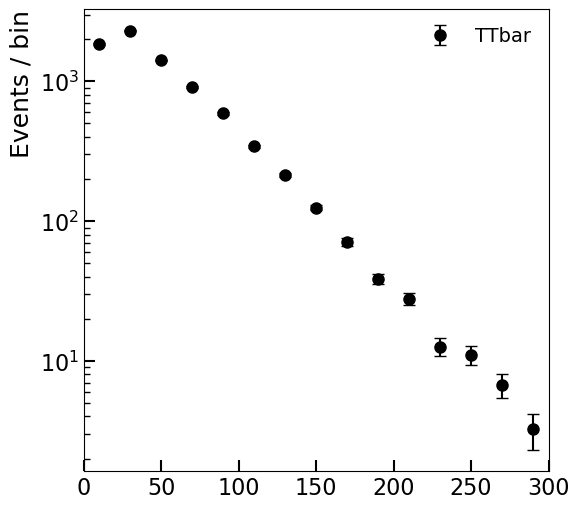

TTbar: 7923.3 ± 45.5 [entries: 36941]
-----------------------------
-----------------------------


In [9]:
df = pd.read_csv('https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/ttbar.csv')
df['sampleID'] = 5
df['MET'] = (df['MET_px']**2 + df['MET_py']**2)**0.5
makePlot(df, var = 'MET', xmin=0, xmax = 300,step_size=20, ylog= True, printOut=False)

sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


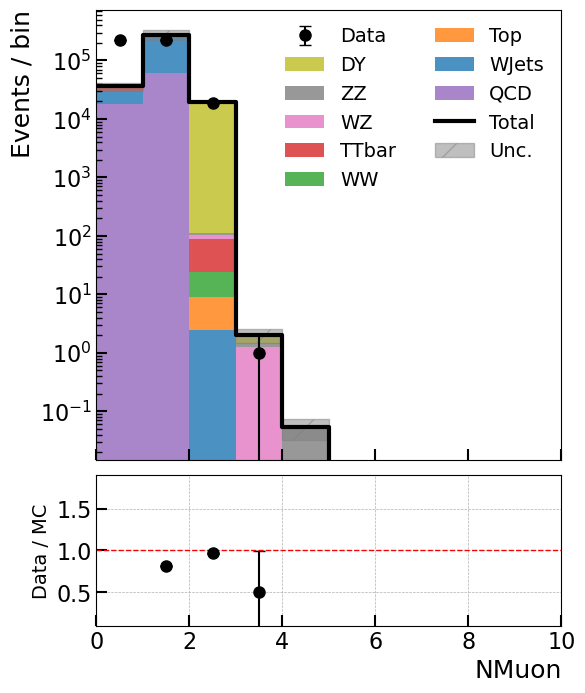

Data: 469384.0 ± 685.1 [entries: 469384]
MC  : 331437.5 ± 55461.7 [entries: 240601]
-----------------------------
QCD  79160.5 ± 55457.2  [entries: 142]
WJets  209603.6 ± 689.2  [entries: 109737]
Top  311.6 ± 4.4  [entries: 5684]
WW  230.0 ± 3.7  [entries: 4580]
TTbar  7929.5 ± 45.5  [entries: 36941]
WZ  69.9 ± 1.3  [entries: 3367]
ZZ  16.9 ± 0.4  [entries: 2421]
DY  34115.6 ± 145.6  [entries: 77729]
-----------------------------


In [10]:
df = pd.read_csv('https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/inclusive.all.csv')
makePlot(df, var = 'NMuon', xmin=0, xmax = 10,step_size=1, ylog= True, printOut=False)

sampleID = 0  Data
sampleID = 1  QCD
sampleID = 2  WJets
sampleID = 3  Top
sampleID = 4  WW
sampleID = 5  TTbar
sampleID = 6  WZ
sampleID = 7  ZZ
sampleID = 8  DY


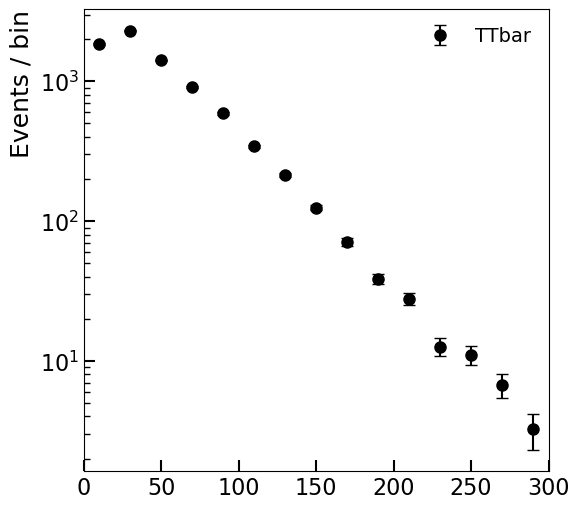

TTbar: 7923.3 ± 45.5 [entries: 36941]
-----------------------------
-----------------------------


In [11]:
df = pd.read_csv('https://theofil.web.cern.ch/theofil/cmsod/files/CSVs/inclusive.all.csv')
df['MET'] = (df['MET_px']**2 + df['MET_py']**2)**0.5
makePlot(df[df.sampleID==5], var = 'MET', xmin=0, xmax = 300,step_size=20, ylog= True, printOut=False, xlabel = 'MET [GeV]')